In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [2]:
!unrar x AML_ASS03.rar



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from AML_ASS03.rar

Creating    AML_ASS03                                                 OK
Extracting  AML_ASS03/AML_ASS03.docx                                       0%  OK 
Extracting  AML_ASS03/test_without_label.csv                               3%  6% 10% 13% 17% 20% 21%  OK 
Extracting  AML_ASS03/train.csv                                           25% 28% 32% 35% 38% 42% 45% 49% 52% 56% 59% 63% 66% 70% 73% 77% 80% 84% 87% 91% 94% 97% 99%  OK 
All OK


In [3]:
train_df = pd.read_csv("AML_ASS03/train.csv")
test_df = pd.read_csv("AML_ASS03/test_without_label.csv")

print("Train Shape:", train_df.shape)
print("Test Shape:", test_df.shape)

train_df.head()


Train Shape: (7160831, 46)
Test Shape: (1614182, 45)


,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,0.000,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,1.569,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2_train
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,7.450,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2_train
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,0.873,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2_train
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,0.000,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2_train


In [4]:
# Create a new DataFrame with cleaned labels (without '_train')
train_cleaned_df = train_df.copy()
train_cleaned_df['label'] = train_cleaned_df['label'].str.replace('_train', '', regex=False)

# Preview
train_cleaned_df.head()

,Header_Length,Protocol Type,Duration,Rate,Srate,Drate,fin_flag_number,syn_flag_number,rst_flag_number,psh_flag_number,...,Std,Tot size,IAT,Number,Magnitue,Radius,Covariance,Variance,Weight,label
0,683.50,17.00,64.0,553148.440,553148.440,0,0.0,0.0,0.0,0.00,...,0.000,50.00,101635944.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2
1,1745.92,16.12,64.0,29919.545,29919.545,0,0.0,0.0,0.0,0.04,...,1.569,52.28,84696616.0,9.5,10.05,2.152,11.785338,0.23,141.5,TCP_IP-DDoS-UDP2
2,2830.36,15.79,64.0,27075.605,27075.605,0,0.0,0.0,0.0,0.06,...,7.450,53.25,84696616.0,9.5,10.35,10.555,113.675460,0.53,141.5,TCP_IP-DDoS-UDP2
3,4087.50,16.89,64.0,19660.156,19660.156,0,0.0,0.0,0.0,0.00,...,0.873,50.16,84696616.0,9.5,10.03,1.236,4.490081,0.18,141.5,TCP_IP-DDoS-UDP2
4,3916.00,17.00,64.0,270322.780,270322.780,0,0.0,0.0,0.0,0.00,...,0.000,50.00,84696616.0,9.5,10.00,0.000,0.000000,0.00,141.5,TCP_IP-DDoS-UDP2


In [7]:
# Check how many missing values exist
print("Missing values in training data:\n", train_cleaned_df.isnull().sum()[train_cleaned_df.isnull().sum() > 0])
print("\nMissing values in test data:\n", test_df.isnull().sum()[test_df.isnull().sum() > 0])

# Handle missing values in training data
for col in train_cleaned_df.columns:
    if train_cleaned_df[col].isnull().sum() > 0:
        if train_cleaned_df[col].dtype in ['int64', 'float64']:
            median_val = train_cleaned_df[col].median()
            train_cleaned_df[col].fillna(median_val, inplace=True)
        else:
            mode_val = train_cleaned_df[col].mode()[0]
            train_cleaned_df[col].fillna(mode_val, inplace=True)

# Handle missing values in test data
for col in test_df.columns:
    if test_df[col].isnull().sum() > 0:
        if test_df[col].dtype in ['int64', 'float64']:
            median_val = test_df[col].median()
            test_df[col].fillna(median_val, inplace=True)
        else:
            mode_val = test_df[col].mode()[0]
            test_df[col].fillna(mode_val, inplace=True)

# Final check to ensure no missing values remain
print("\nAll missing values handled.")
print("Train missing:", train_cleaned_df.isnull().sum().sum())
print("Test missing:", test_df.isnull().sum().sum())


Missing values in training data:
 Series([], dtype: int64)

Missing values in test data:
 Series([], dtype: int64)

All missing values handled.
Train missing: 0
Test missing: 0


In [8]:
# Initialize label encoder
label_encoder = LabelEncoder()

# Fit and transform the 'label' column in the cleaned DataFrame
train_cleaned_df['label'] = label_encoder.fit_transform(train_cleaned_df['label'])

# Check the mapping of labels to integers
print("Encoded Labels Mapping:")
for index, class_ in enumerate(label_encoder.classes_):
    print(f"{index}: {class_}")

Encoded Labels Mapping:
0: ARP_Spoofing
1: Benign
2: MQTT-DDoS-Connect_Flood
3: MQTT-DDoS-Publish_Flood
4: MQTT-DoS-Connect_Flood
5: MQTT-DoS-Publish_Flood
6: MQTT-Malformed_Data
7: Recon-OS_Scan
8: Recon-Ping_Sweep
9: Recon-Port_Scan
10: Recon-VulScan
11: TCP_IP-DDoS-ICMP1
12: TCP_IP-DDoS-ICMP2
13: TCP_IP-DDoS-ICMP3
14: TCP_IP-DDoS-ICMP4
15: TCP_IP-DDoS-ICMP5
16: TCP_IP-DDoS-ICMP6
17: TCP_IP-DDoS-ICMP7
18: TCP_IP-DDoS-ICMP8
19: TCP_IP-DDoS-SYN1
20: TCP_IP-DDoS-SYN2
21: TCP_IP-DDoS-SYN3
22: TCP_IP-DDoS-SYN4
23: TCP_IP-DDoS-TCP1
24: TCP_IP-DDoS-TCP2
25: TCP_IP-DDoS-TCP3
26: TCP_IP-DDoS-TCP4
27: TCP_IP-DDoS-UDP1
28: TCP_IP-DDoS-UDP2
29: TCP_IP-DDoS-UDP3
30: TCP_IP-DDoS-UDP4
31: TCP_IP-DDoS-UDP5
32: TCP_IP-DDoS-UDP6
33: TCP_IP-DDoS-UDP7
34: TCP_IP-DDoS-UDP8
35: TCP_IP-DoS-ICMP1
36: TCP_IP-DoS-ICMP2
37: TCP_IP-DoS-ICMP3
38: TCP_IP-DoS-ICMP4
39: TCP_IP-DoS-SYN1
40: TCP_IP-DoS-SYN2
41: TCP_IP-DoS-SYN3
42: TCP_IP-DoS-SYN4
43: TCP_IP-DoS-TCP1
44: TCP_IP-DoS-TCP2
45: TCP_IP-DoS-TCP3
46: TCP_IP-

In [9]:
# Separate features (X) and target (y)
X = train_cleaned_df.drop(columns=['label'])
y = train_cleaned_df['label']

# Initialize and fit scaler on training data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply the same transformation to test data
test_scaled = scaler.transform(test_df)

# Convert scaled data back to DataFrame (for analysis or plotting)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.columns)

print("Feature scaling complete. Data is standardized.")


Feature scaling complete. Data is standardized.


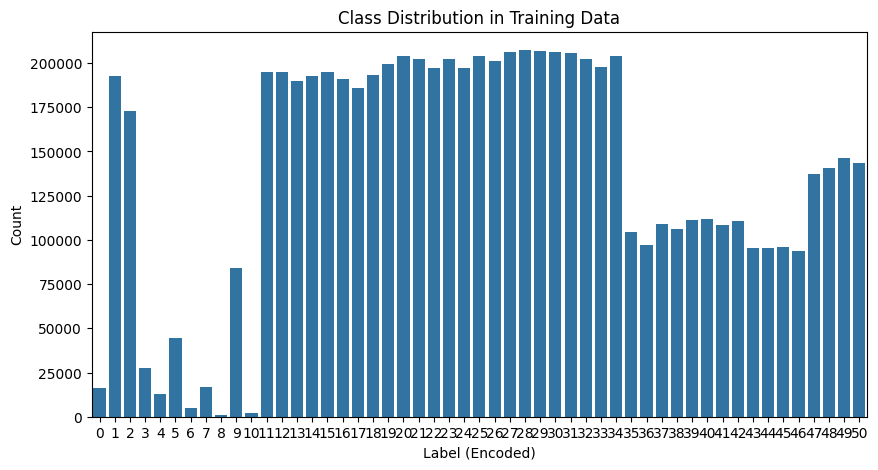

Class counts:
 label
28    207295
29    206604
30    206343
27    206170
31    205507
34    204105
25    204075
20    203669
23    202311
32    202247
21    202023
26    200998
19    199390
33    197685
24    197081
22    196880
15    195032
11    194938
12    194818
18    193340
14    192741
1     192732
16    190875
13    189710
17    186022
2     173036
49    146146
50    143301
48    140492
47    137011
40    111647
39    111431
42    110635
37    108686
41    108190
38    106122
35    104507
36     96977
45     95968
44     95521
43     95407
46     93488
9      83981
5      44376
3      27623
7      16832
0      16047
4      12773
6       5130
10      2173
8        740
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x=y)
plt.title("Class Distribution in Training Data")
plt.xlabel("Label (Encoded)")
plt.ylabel("Count")
plt.show()

# See value counts
print("Class counts:\n", y.value_counts())


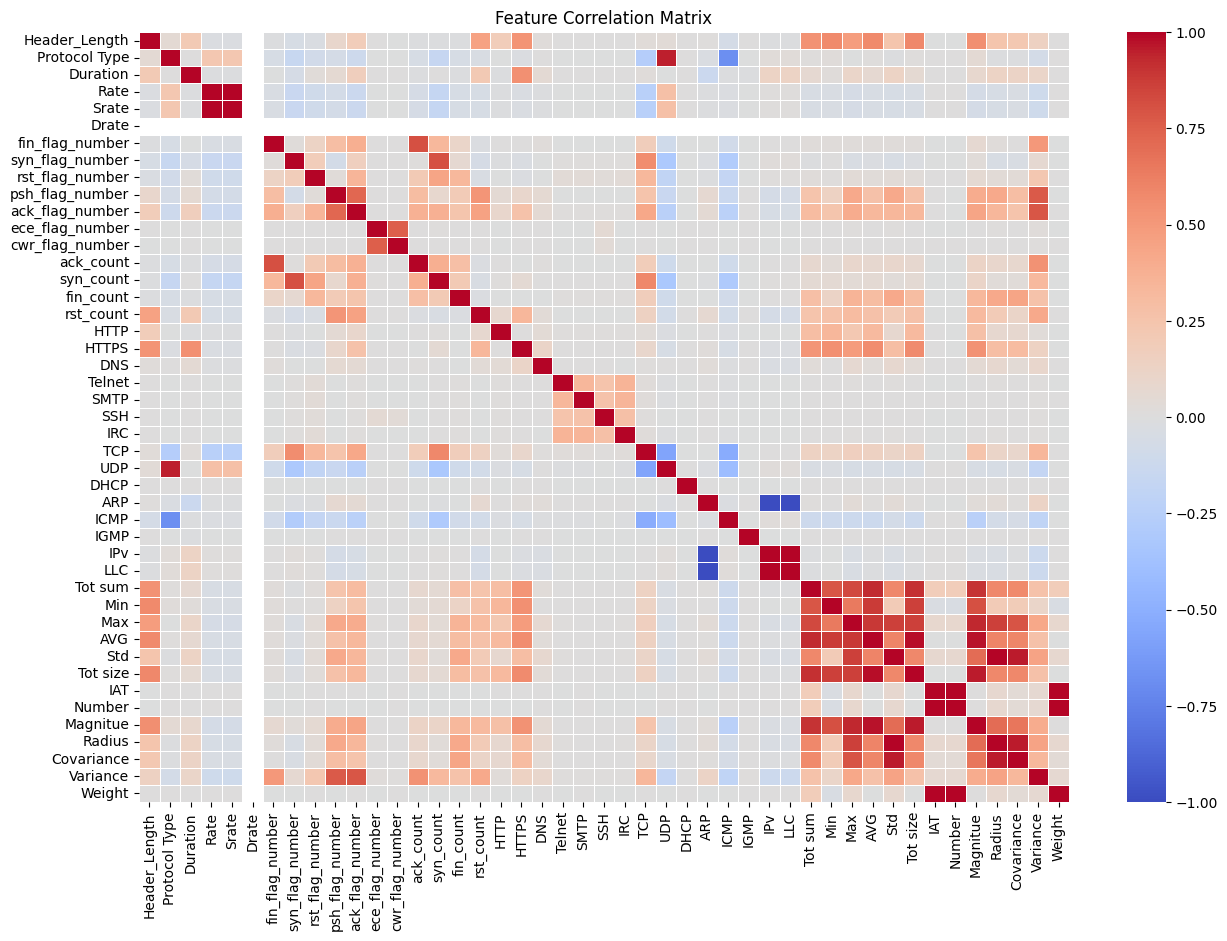

In [11]:
# Correlation heatmap on scaled features
plt.figure(figsize=(15, 10))
sns.heatmap(X_scaled_df.corr(), cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [12]:
# SUMMARY STATISTICS
X_scaled_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Header_Length,7160831.0,-1.536222e-17,1.0,-0.107103,-0.106907,-0.106712,-0.036226,35.712671
Protocol Type,7160831.0,-1.470153e-15,1.0,-1.278238,-1.093885,-0.324684,1.423498,1.423498
Duration,7160831.0,9.446224e-16,1.0,-7.703202,-0.088817,-0.088817,-0.088817,22.635362
Rate,7160831.0,-8.677141e-17,1.0,-0.385526,-0.385357,-0.381849,0.099084,52.693929
Srate,7160831.0,-8.677141e-17,1.0,-0.385526,-0.385357,-0.381849,0.099084,52.693929
Drate,7160831.0,0.000000e+00,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
fin_flag_number,7160831.0,5.397593e-16,1.0,-0.148909,-0.148909,-0.148909,-0.148909,29.166550
syn_flag_number,7160831.0,-1.125647e-15,1.0,-0.468566,-0.468566,-0.468566,-0.468566,2.482826
rst_flag_number,7160831.0,-4.866454e-16,1.0,-0.281699,-0.281699,-0.281699,-0.281699,7.012163
psh_flag_number,7160831.0,7.774341e-16,1.0,-0.230683,-0.230683,-0.230683,-0.230683,10.064643


In [13]:
#APPLY PCA TO REDUCE DIMENSIONS
pca = PCA(n_components=30)  # You can tune this number
X_pca = pca.fit_transform(X_scaled)
test_pca = pca.transform(test_scaled)

print("PCA applied. New shape of training data:", X_pca.shape)

PCA applied. New shape of training data: (7160831, 30)


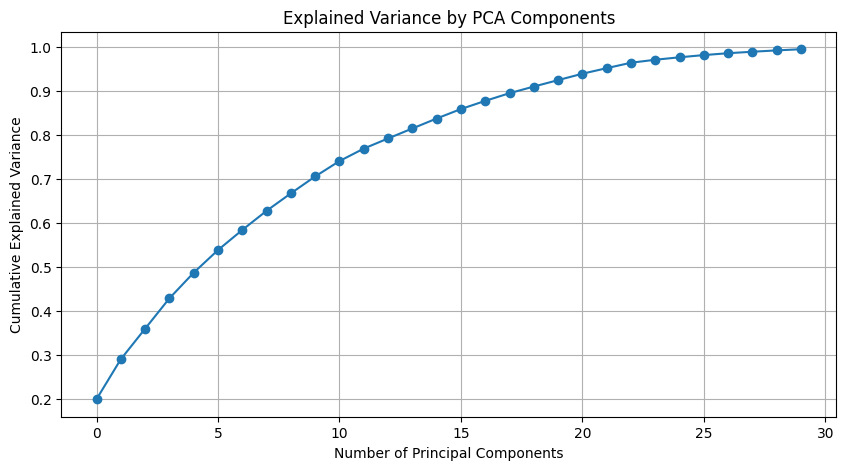

In [14]:
# Cumulative explained variance plot
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()


In [17]:
# Split the PCA-transformed data
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.2, random_state=42, stratify=y)

print("Training set size:", X_train.shape)
print("Validation set size:", X_val.shape)


Training set size: (5728664, 30)
Validation set size: (1432167, 30)


In [18]:
import time
start_time = time.time()

# Initialize and train Random Forest using all cores
model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

end_time = time.time()
print("Model training complete.")
print(f"Training time: {(end_time - start_time):.2f} seconds")


Model training complete.
Training time: 1700.97 seconds


In [19]:
# Save the trained model to a file
import joblib
model_filename = 'random_forest_model.joblib'
joblib.dump(model, model_filename)

print(f"Model saved to {model_filename}")

Model saved to random_forest_model.joblib


In [ ]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(model, X_pca, y, cv=5)

print("Cross-validation scores:", cv_scores)
print("Average CV accuracy:", np.mean(cv_scores))


In [20]:
import joblib

# Load the model from the correct path
model = joblib.load("random_forest_model.joblib")

# Predict on the validation set
y_pred = model.predict(X_val)

print("Prediction complete.")


Prediction complete.


In [21]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision (macro):", precision_score(y_val, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_val, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_val, y_pred, average='macro'))

# Detailed report
print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.6459749456592702
Precision (macro): 0.7202003414308674
Recall (macro): 0.6670268561467764
F1 Score (macro): 0.6755652694467162

Classification Report:
                         precision    recall  f1-score   support

           ARP_Spoofing       0.73      0.57      0.64      3209
                 Benign       0.93      0.98      0.96     38547
MQTT-DDoS-Connect_Flood       0.99      1.00      1.00     34607
MQTT-DDoS-Publish_Flood       1.00      0.99      0.99      5525
 MQTT-DoS-Connect_Flood       0.99      0.89      0.94      2555
 MQTT-DoS-Publish_Flood       0.99      1.00      1.00      8875
    MQTT-Malformed_Data       0.73      0.49      0.59      1026
          Recon-OS_Scan       0.84      0.39      0.53      3366
       Recon-Ping_Sweep       0.84      0.65      0.73       148
        Recon-Port_Scan       0.88      0.94      0.91     16796
          Recon-VulScan       0.60      0.25      0.35       435
      TCP_IP-DDoS-ICMP1       0.89      0.82      0.86  

In [47]:
!pip install xgboost tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 MB 3.4 MB/s eta 0:00:00


In [49]:
import time
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import xgboost as xgb

# Verify TensorFlow version and runtime type
print("TensorFlow version:", tf.__version__)
# Check runtime type (should be TPU if selected in Colab)
try:
    runtime_type = tf.config.list_physical_devices()
    print("Available devices:", runtime_type)
except:
    print("Unable to list physical devices.")

# Detect and initialize TPU with error handling
strategy = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    # Safely check for TPU workers
    cluster_spec = tpu.cluster_spec().as_dict()
    if 'worker' in cluster_spec:
        print('Running on TPU:', cluster_spec['worker'])
    else:
        print("TPU detected, but 'worker' key not found in cluster spec:", cluster_spec)

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU initialized with", tpu.num_accelerators()['TPU'])
except ValueError as e:
    print("TPU initialization failed:", e)
    print("Falling back to CPU/GPU")
    strategy = tf.distribute.get_strategy()
except Exception as e:
    print("Unexpected error during TPU setup:", e)
    print("Falling back to CPU/GPU")
    strategy = tf.distribute.get_strategy()

# Convert data to TensorFlow Dataset for preprocessing
def create_dataset(X, y=None, batch_size=1024):
    dataset = tf.data.Dataset.from_tensor_slices((X, y) if y is not None else (X,))
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Preprocess data (use TPU if available, otherwise CPU/GPU)
with strategy.scope():
    try:
        X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
        y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.int32)
        X_val_tf = tf.convert_to_tensor(X_val, dtype=tf.float32)
        y_val_tf = tf.convert_to_tensor(y_val, dtype=tf.int32)
        test_pca_tf = tf.convert_to_tensor(test_pca, dtype=tf.float32)

        # Convert back to NumPy for XGBoost
        X_train_np = X_train_tf.numpy()
        y_train_np = y_train_tf.numpy()
        X_val_np = X_val_tf.numpy()
        y_val_np = y_val_tf.numpy()
        test_pca_np = test_pca_tf.numpy()
    except Exception as e:
        print("Error during data preprocessing:", e)
        # Fallback to original data if tensor conversion fails
        X_train_np, y_train_np = X_train, y_train
        X_val_np, y_val_np = X_val, y_val
        test_pca_np = test_pca

# Train XGBoost model (on CPU, as TPU is not natively supported)
start_time = time.time()
model_xgb = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train_np, y_train_np)

# End training time
end_time = time.time()
print("Model training complete.")
print(f"Training time: {(end_time - start_time):.2f} seconds")

# Save the model
import joblib
joblib.dump(model_xgb, "xgboost_tpu_preprocessed_model.joblib")
print("Model saved as 'xgboost_tpu_preprocessed_model.joblib'")

# Predict on the validation set
y_pred = model_xgb.predict(X_val_np)
print("Prediction complete.")
print("Accuracy:", accuracy_score(y_val_np, y_pred))
print("Precision (macro):", precision_score(y_val_np, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_val_np, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_val_np, y_pred, average='macro'))

# Detailed report
print("\nClassification Report:")
print(classification_report(y_val_np, y_pred, target_names=label_encoder.classes_))

# Predict on unseen test data
test_predictions_encoded = model_xgb.predict(test_pca_np)
test_predictions_labels = label_encoder.inverse_transform(test_predictions_encoded)


TensorFlow version: 2.18.0
Available devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:TPU_SYSTEM:0', device_type='TPU_SYSTEM'), PhysicalDevice(name='/physical_device:TPU:0', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:1', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:2', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:3', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:4', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:5', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:6', device_type='TPU'), PhysicalDevice(name='/physical_device:TPU:7', device_type='TPU')]
TPU detected, but 'worker' key not found in cluster spec: {}
TPU initialized with 8
Model training complete.
Training time: 1499.71 seconds
Model saved as 'xgboost_tpu_preprocessed_model.joblib'
Prediction complete.
Accuracy: 0.26643610696238634


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision (macro): 0.2478474994332797
Recall (macro): 0.24981156305263055
F1 Score (macro): 0.22936193150952905

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

           ARP_Spoofing       0.00      0.00      0.00      3209
                 Benign       0.84      0.90      0.87     38547
MQTT-DDoS-Connect_Flood       0.92      0.96      0.94     34607
MQTT-DDoS-Publish_Flood       0.35      0.02      0.04      5525
 MQTT-DoS-Connect_Flood       0.00      0.00      0.00      2555
 MQTT-DoS-Publish_Flood       0.92      0.83      0.88      8875
    MQTT-Malformed_Data       0.00      0.00      0.00      1026
          Recon-OS_Scan       0.00      0.00      0.00      3366
       Recon-Ping_Sweep       0.00      0.00      0.00       148
        Recon-Port_Scan       0.68      0.82      0.74     16796
          Recon-VulScan       0.00      0.00      0.00       435
      TCP_IP-DDoS-ICMP1       0.27      0.26      0.27     38988
      TCP_IP-DDoS-ICMP2       0.39      0.26      0.31     38964
      TCP_IP-DDoS-ICMP3       0.31      0.05      0.08     37942
      TCP_IP-DDoS-ICMP4 

In [50]:
# Predict on unseen test data
test_predictions_encoded = model_xgb.predict(test_pca_np)
test_predictions_labels = label_encoder.inverse_transform(test_predictions_encoded)


In [51]:

# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "index": range(len(test_predictions_labels)),
    "label": test_predictions_labels
})

print(submission_df.head())

# Save the submission file
submission_df.to_csv("submission_xgb.csv", index=False)
print("File Saved Successfully as 'submission_xgb_tpu.csv'")

   index              label
0      0    TCP_IP-DoS-SYN1
1      1  TCP_IP-DDoS-ICMP6
2      2   TCP_IP-DDoS-SYN3
3      3   TCP_IP-DoS-ICMP2
4      4    TCP_IP-DoS-TCP2
File Saved Successfully as 'submission_xgb_tpu.csv'


In [53]:
# Keep only the first 1,048,575 rows
submission_df = submission_df.iloc[:1048575, :]

# Save the submission file
submission_df.to_csv("submission_xgb_file.csv", index=False)
print("File saved successfully with", submission_df.shape[0], "rows.")

File saved successfully with 1048575 rows.


In [55]:
from google.colab import files
# Download the file from Colab
files.download("submission_xgb_file.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

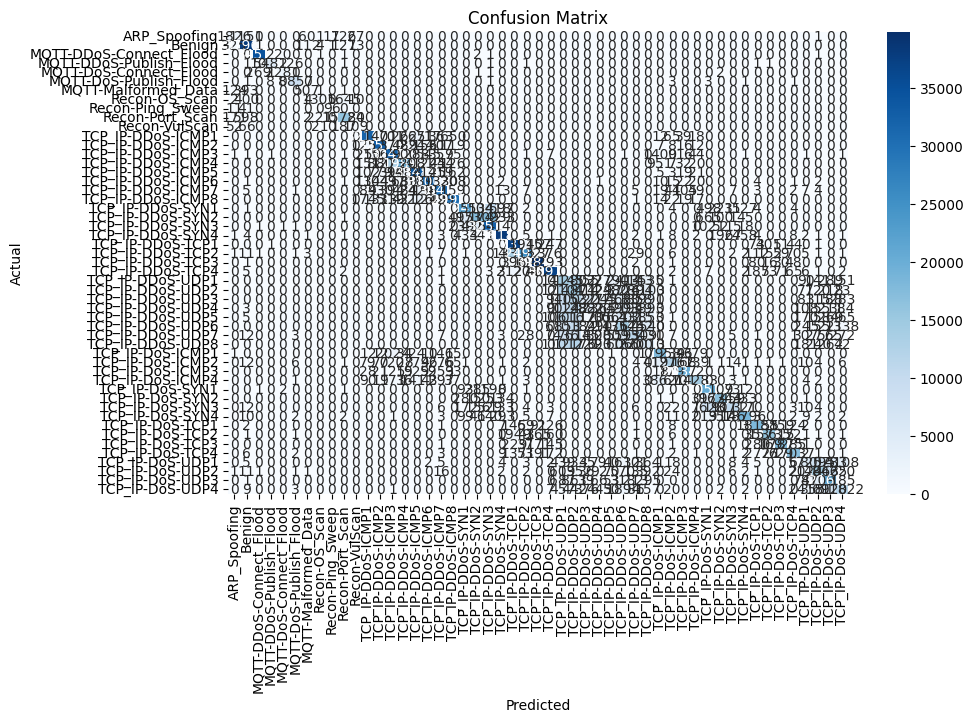

In [23]:
# Compute and visualize confusion matrix
cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [24]:
# PREDICT ON UNSEEN TEST DATA
test_pca.shape
test_predictions_encoded = model.predict(test_pca)

# Convert numeric predictions back to original string labels
test_predictions_labels = label_encoder.inverse_transform(test_predictions_encoded)


In [29]:
# Prepare submission DataFrame
submission_df = pd.DataFrame({
    "index": range(len(test_predictions_labels)),
    "label": test_predictions_labels
})

print(submission_df.head())

# Save the submission file
submission_df.to_csv("submission.csv", index=False)
print("File Saved Successfully.")


   index              label
0      0    TCP_IP-DoS-SYN3
1      1  TCP_IP-DDoS-ICMP7
2      2   TCP_IP-DDoS-SYN3
3      3   TCP_IP-DoS-ICMP3
4      4    TCP_IP-DoS-TCP4
File Saved Successfully.


In [32]:
# Keep only the first 1,048,575 rows
submission_df = submission_df.iloc[:1048575, :]

# Save the submission file
submission_df.to_csv("submission_file.csv", index=False)
print("File saved successfully with", submission_df.shape[0], "rows.")

File saved successfully with 1048575 rows.


In [33]:
submission_df.shape

(1048575, 2)

In [35]:
# Check row count
assert submission_df.shape[0] == 1048575, "ERROR: submission.csv must have exactly 1048575 rows."

# Check column names
assert list(submission_df.columns) == ['index', 'label'], "ERROR: submission.csv must have columns: Id, label"


In [36]:
import zipfile

input_file = 'random_forest_model.joblib'
output_zip = 'model_compressed.zip'

with zipfile.ZipFile(output_zip, 'w', compression=zipfile.ZIP_DEFLATED, compresslevel=9) as zipf:
    zipf.write(input_file)

print(f"Compressed file saved as {output_zip}")


Compressed file saved as model_compressed.zip


In [37]:
import os

zip_filename = 'model_compressed.zip'

# Get size in bytes
size_bytes = os.path.getsize(zip_filename)

# Convert to KB or MB for easier reading
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"File size: {size_bytes} bytes")
print(f"File size: {size_kb:.2f} KB")
print(f"File size: {size_mb:.2f} MB")


File size: 386741364 bytes
File size: 377677.11 KB
File size: 368.83 MB


In [41]:
from google.colab import files

files.download('model_compressed.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>